In [7]:
import pandas as pd
import numpy as np
from datetime import date
# Carregue seu arquivo CSV. O 'index_col' garante que a coluna de índice não será usada.
df = pd.read_csv(r"C:\Users\b.teixeira\Downloads\negociospex.csv",sep=';')

In [8]:
# Crie uma lista de estados e cidades de exemplo
estados_br = ['SP', 'RJ', 'MG', 'BA', 'RS']
cidades_por_estado = {
    'SP': ['São Paulo', 'Campinas', 'Guarulhos'],
    'RJ': ['Rio de Janeiro', 'Niterói', 'Petrópolis'],
    'MG': ['Belo Horizonte', 'Uberlândia', 'Ouro Preto'],
    'BA': ['Salvador', 'Feira de Santana', 'Vitória da Conquista'],
    'RS': ['Porto Alegre', 'Gramado', 'Caxias do Sul']
}

# Lista de DDDs comuns no Brasil
ddds_br = [11, 21, 31, 71, 51]

n_linhas = 6002

In [9]:

# Solução: Gerar o CPF como uma string de 11 dígitos aleatórios.
df['CPF'] = [''.join(np.random.choice(list('0123456789'), 11)) for _ in range(n_linhas)]

# Solução: Gerar datas de forma mais segura.
data_inicio = pd.to_datetime('1960-01-01')
data_fim = pd.to_datetime('2005-01-01')

# Calcule o intervalo de tempo em dias
dias_intervalo = (data_fim - data_inicio).days

# Gere um número aleatório de dias para cada cliente
dias_aleatorios = np.random.randint(0, dias_intervalo, n_linhas)

# Adicione o número de dias à data inicial
datas_nasc = data_inicio + pd.to_timedelta(dias_aleatorios, unit='D')
df['Data de nascimento'] = datas_nasc.strftime('%Y-%m-%d')

# Preencher as colunas 'Estado' e 'DDD'
df['Estado'] = np.random.choice(estados_br, size=n_linhas)
df['DDD'] = df['Estado'].apply(lambda x: ddds_br[estados_br.index(x)])

# Preencher a coluna 'Cidade' com base no 'Estado'
df['Cidade'] = [np.random.choice(cidades_por_estado[estado]) for estado in df['Estado']]

# Opcional: Para misturar bem as cidades, você pode embaralhar os dados novamente
df['Cidade'] = np.random.permutation(df['Cidade'])

In [10]:
df['Data de nascimento'] = pd.to_datetime(df['Data de nascimento'])

In [11]:
def calcular_idade(data_nascimento):
    hoje = date.today()
    return hoje.year - data_nascimento.year - ((hoje.month, hoje.day) < (data_nascimento.month, data_nascimento.day))

In [12]:
df['idade'] = df['Data de nascimento'].apply(calcular_idade)

In [17]:
colunas_categoricas = [
    'Segmento', 'Canal de Vendas', 'Canal', 'Estado', 
    'Cidade', 'DDD', 'Forma de pagamento', 'Serviço','Plano Contratado'
]

In [20]:
df_categoricas_dummies = pd.get_dummies(df[colunas_categoricas], drop_first=True)
# 2. Limpar e Converter Colunas Numéricas
# Corrigir a coluna 'GB contratados'
df['GB'] = df['GB'].astype(str).str.replace(',', '.', regex=False).astype(float)
# Corrigir a coluna 'Valor do plano' (caso também tenha vírgulas)
df['Renda'] = df['Renda'].astype(str).str.replace(',', '.', regex=False).astype(float)

In [21]:
df_final = pd.concat([
    df[['idade', 'GB', 'Renda']].astype(float), # Converte para numérico
    df_categoricas_dummies
], axis=1)

In [26]:

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from kneed import KneeLocator

# 1. Instanciar o padronizador
scaler = StandardScaler()

# 2. Aplicar o padronizador ao DataFrame
df_padronizado = pd.DataFrame(scaler.fit_transform(df_final), columns=df_final.columns)

In [27]:
# 3. Exibir o DataFrame após a padronização
print("\n---")
print("DataFrame após a padronização:")
print(df_padronizado.describe())


---
DataFrame após a padronização:
              idade            GB         Renda           DDD  \
count  6.002000e+03  6.002000e+03  6.002000e+03  6.002000e+03   
mean  -1.237116e-16 -8.523672e-17 -6.866291e-17  8.790036e-17   
std    1.000083e+00  1.000083e+00  1.000083e+00  1.000083e+00   
min   -1.784440e+00 -2.136999e+00 -1.536543e+00 -1.201779e+00   
25%   -8.528003e-01 -2.301549e-01 -7.504150e-01 -7.373184e-01   
50%    1.202967e-03  8.765252e-02  2.328593e-01 -2.728573e-01   
75%    8.552062e-01  4.054599e-01  5.278416e-01  6.560648e-01   
max    1.709209e+00  7.158867e+00  7.656580e+00  1.584987e+00   

       Segmento_Express  Segmento_Pré-Pago Combo  Segmento_Pós Pago  \
count      6.002000e+03             6.002000e+03       6.002000e+03   
mean       9.470746e-18             2.367687e-18       1.183843e-18   
std        1.000083e+00             1.000083e+00       1.000083e+00   
min       -3.436674e-01            -4.495363e-01      -9.257423e-02   
25%       -3.436674e-01

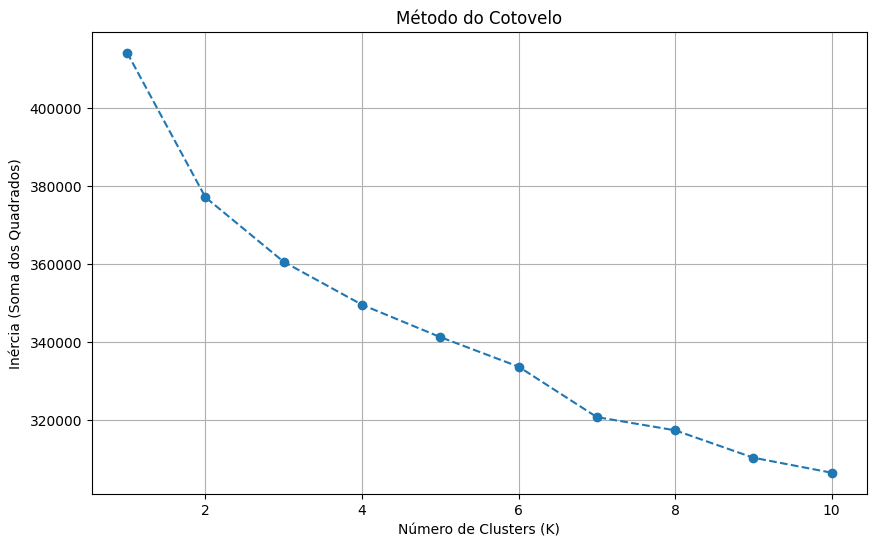


O número ideal de clusters (método do cotovelo) é: 7


In [28]:
# Vamos usar os dados padronizados
X = df_padronizado

# Lista para armazenar a inércia (soma dos quadrados) para cada K
inercia = []

# Testar de 1 a 10 clusters
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=42)
    kmeans.fit(X)
    inercia.append(kmeans.inertia_)

# Plotar o gráfico do Cotovelo
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inercia, marker='o', linestyle='--')
plt.title('Método do Cotovelo')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inércia (Soma dos Quadrados)')
plt.grid(True)
plt.show()

# Opcional: Usar a biblioteca kneed para encontrar o cotovelo automaticamente
cotovelo = KneeLocator(range(1, 11), inercia, curve='convex', direction='decreasing')
print(f"\nO número ideal de clusters (método do cotovelo) é: {cotovelo.elbow}")

In [30]:
kmeans = KMeans(n_clusters=7, init='k-means++', n_init=10, max_iter=300, random_state=42)
kmeans.fit(df_padronizado)

# 2. Atribuir os rótulos dos clusters ao DataFrame original
# Isso nos permite analisar os grupos com os dados originais
df['cluster_label'] = kmeans.labels_

# 3. Analisar as características de cada cluster
# Agrupe o DataFrame pelo cluster e calcule a média das colunas importantes
perfil_clusters = df.groupby('cluster_label').agg({
    'idade': 'mean',
    'GB': 'mean',
    'Renda': 'mean',
    'Segmento': lambda x: x.mode()[0],
    'Canal de Vendas': lambda x: x.mode()[0],
    'Estado': lambda x: x.mode()[0],
    'Serviço': lambda x: x.mode()[0],
    'Plano Contratado': lambda x: x.mode()[0]
}).reset_index()

# Renomear as colunas para melhor visualização
perfil_clusters.columns = [
    'Cluster', 'Idade Média', 'GB Contratados Médios', 
    'Valor do Plano Médio', 'Segmento Dominante', 
    'Canal de Vendas Dominante', 'Estado Dominante', 
    'Serviço Dominante', 'Plano Contratado Dominante'
]

# Exibir o perfil de cada cluster
print("---")
print("Perfil de cada Cluster:")
print(perfil_clusters)
df.to_csv('clientes_segmentados.csv', index=False)

---
Perfil de cada Cluster:
   Cluster  Idade Média  GB Contratados Médios  Valor do Plano Médio  \
0        0    42.861249              12.000000             23.563925   
1        1    44.218045              48.348371             92.797018   
2        2    41.839937              37.253566             63.284770   
3        3    42.876601              28.877765             60.044715   
4        4    43.183656              26.184920             42.323614   
5        5    43.121951              40.034146             65.181220   
6        6    47.909091              85.030303            142.111212   

  Segmento Dominante Canal de Vendas Dominante Estado Dominante  \
0     Pré-Pago Combo                    Varejo               SP   
1           Controle                   Digital               SP   
2            Express                    Varejo               MG   
3           Controle                   Digital               SP   
4           Controle                    Varejo              